In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []
print("seed",seed)

print(datetime.datetime.now())

seed 4
2023-07-08 20:37:00.024221


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(-3.7685)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(6.8243)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(61.8634)
train_loss:  -5.453928391504287
valid_loss:  -1.991798129558563
h_min_tilde -6.162118 ell_tilde -4.761502339115142 kappa_tilde 0.0008449684970676621
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -0.829502913939953
valid_loss:  0.38190941857099536
weight_alpha 1.0 h_min_tilde -6.162118 ell_tilde -0.5872204474377632 kappa_tilde 0.00042352744291541554


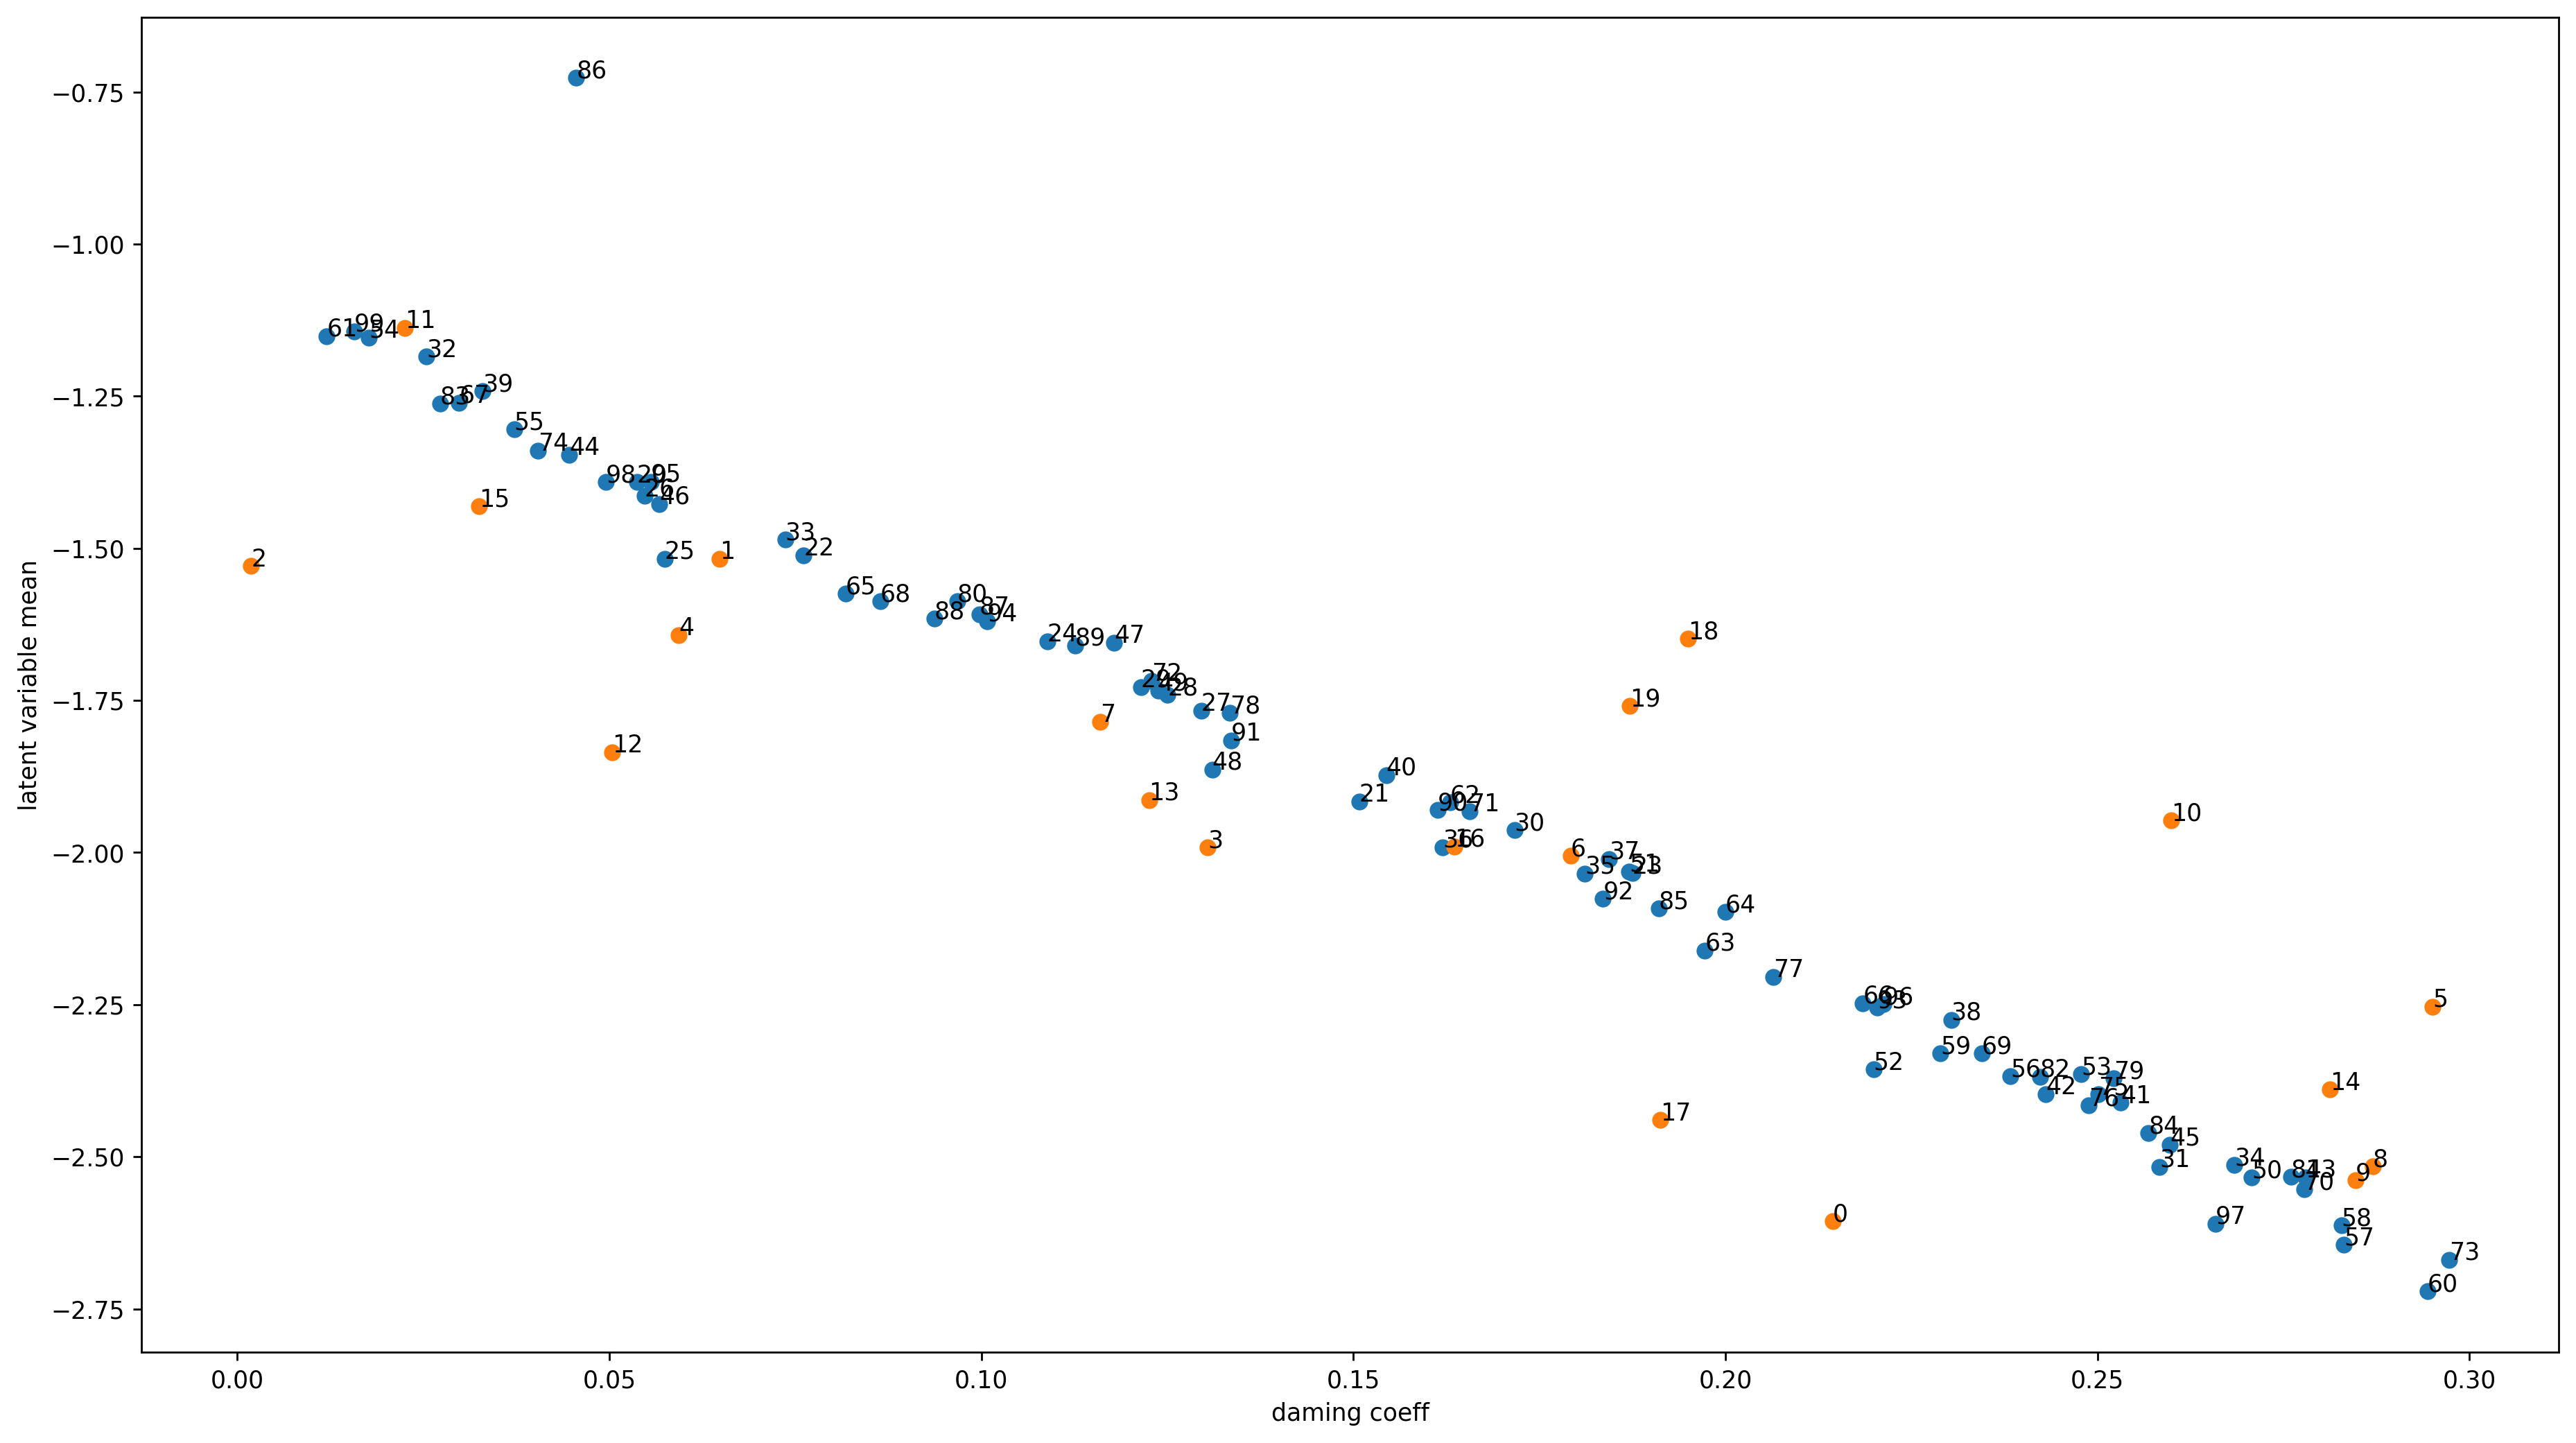

[0.2144448  0.06482685 0.00186908 0.13043746 0.05930552 0.2950202
 0.17920018 0.11597138 0.28699589 0.28469319]
[0.25988679 0.02248458 0.05039166 0.12253316 0.28127148 0.03245801
 0.1635608  0.19128307 0.19494153 0.18717483]
[0.05369217 0.15075992 0.07610389 0.18747925 0.10885608 0.05743392
 0.05473362 0.12954662 0.12503289 0.12144757]
[0.17164163 0.25830429 0.02539848 0.07363611 0.26839539 0.18106905
 0.16202242 0.18436885 0.23032741 0.03294544]
[0.15439611 0.2531121  0.24304333 0.27801621 0.04461805 0.25973247
 0.05670773 0.11783435 0.13102989 0.12374166]
[0.27072656 0.18707065 0.21989962 0.24780686 0.01766403 0.03720439
 0.238327   0.28313925 0.28277575 0.22889809]
[0.29436298 0.01202734 0.16298709 0.19724539 0.19996752 0.08174144
 0.21848083 0.02979833 0.08641105 0.23445934]
[0.27774258 0.16557793 0.12287742 0.29723905 0.04042578 0.25013441
 0.24882538 0.20646638 0.1333622  0.25213982]
[0.09677249 0.2759962  0.24226469 0.02727317 0.25685513 0.1910546
 0.04556568 0.09974855 0.093661

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.963343381881714

 2 3.2390596866607666

 3 3.5692951679229736

 4 3.2787678241729736

 5 3.294510841369629

 6 3.640429735183716

 7 3.2664976119995117

 8 3.1726279258728027

 9 3.624119520187378

 10 3.8814971446990967

 11 3.661715507507324

 12 3.8201515674591064

 13 3.6349380016326904

 14 4.212719440460205

 15 3.771700859069824

 16 3.6997604370117188

 17 3.6823956966400146

 18 3.4156301021575928

 19 3.394434690475464

 20 3.750041961669922

 21 3.449587821960449

 22 3.5779855251312256

 23 3.5918869972229004

 24 3.625192880630493

 25 3.4202919006347656

 26 3.3420708179473877

 27 3.468916893005371

 28 3.4383199214935303

 29 3.565800905227661

 30 3.6568169593811035

 31 3.547356605529785

 32 3.567440986633301

 33 3.739274263381958

 34 3.6209185123443604

 35 3.6893081665039062

 36 3.593841075897217

 37 3.5301167964935303

 38 3.6120212078094482

 39 3.7205958366394043

 40 3.649613618850708

 41 3.6599907875061035

 42 3.698986053466797

 43 3.6904511451721

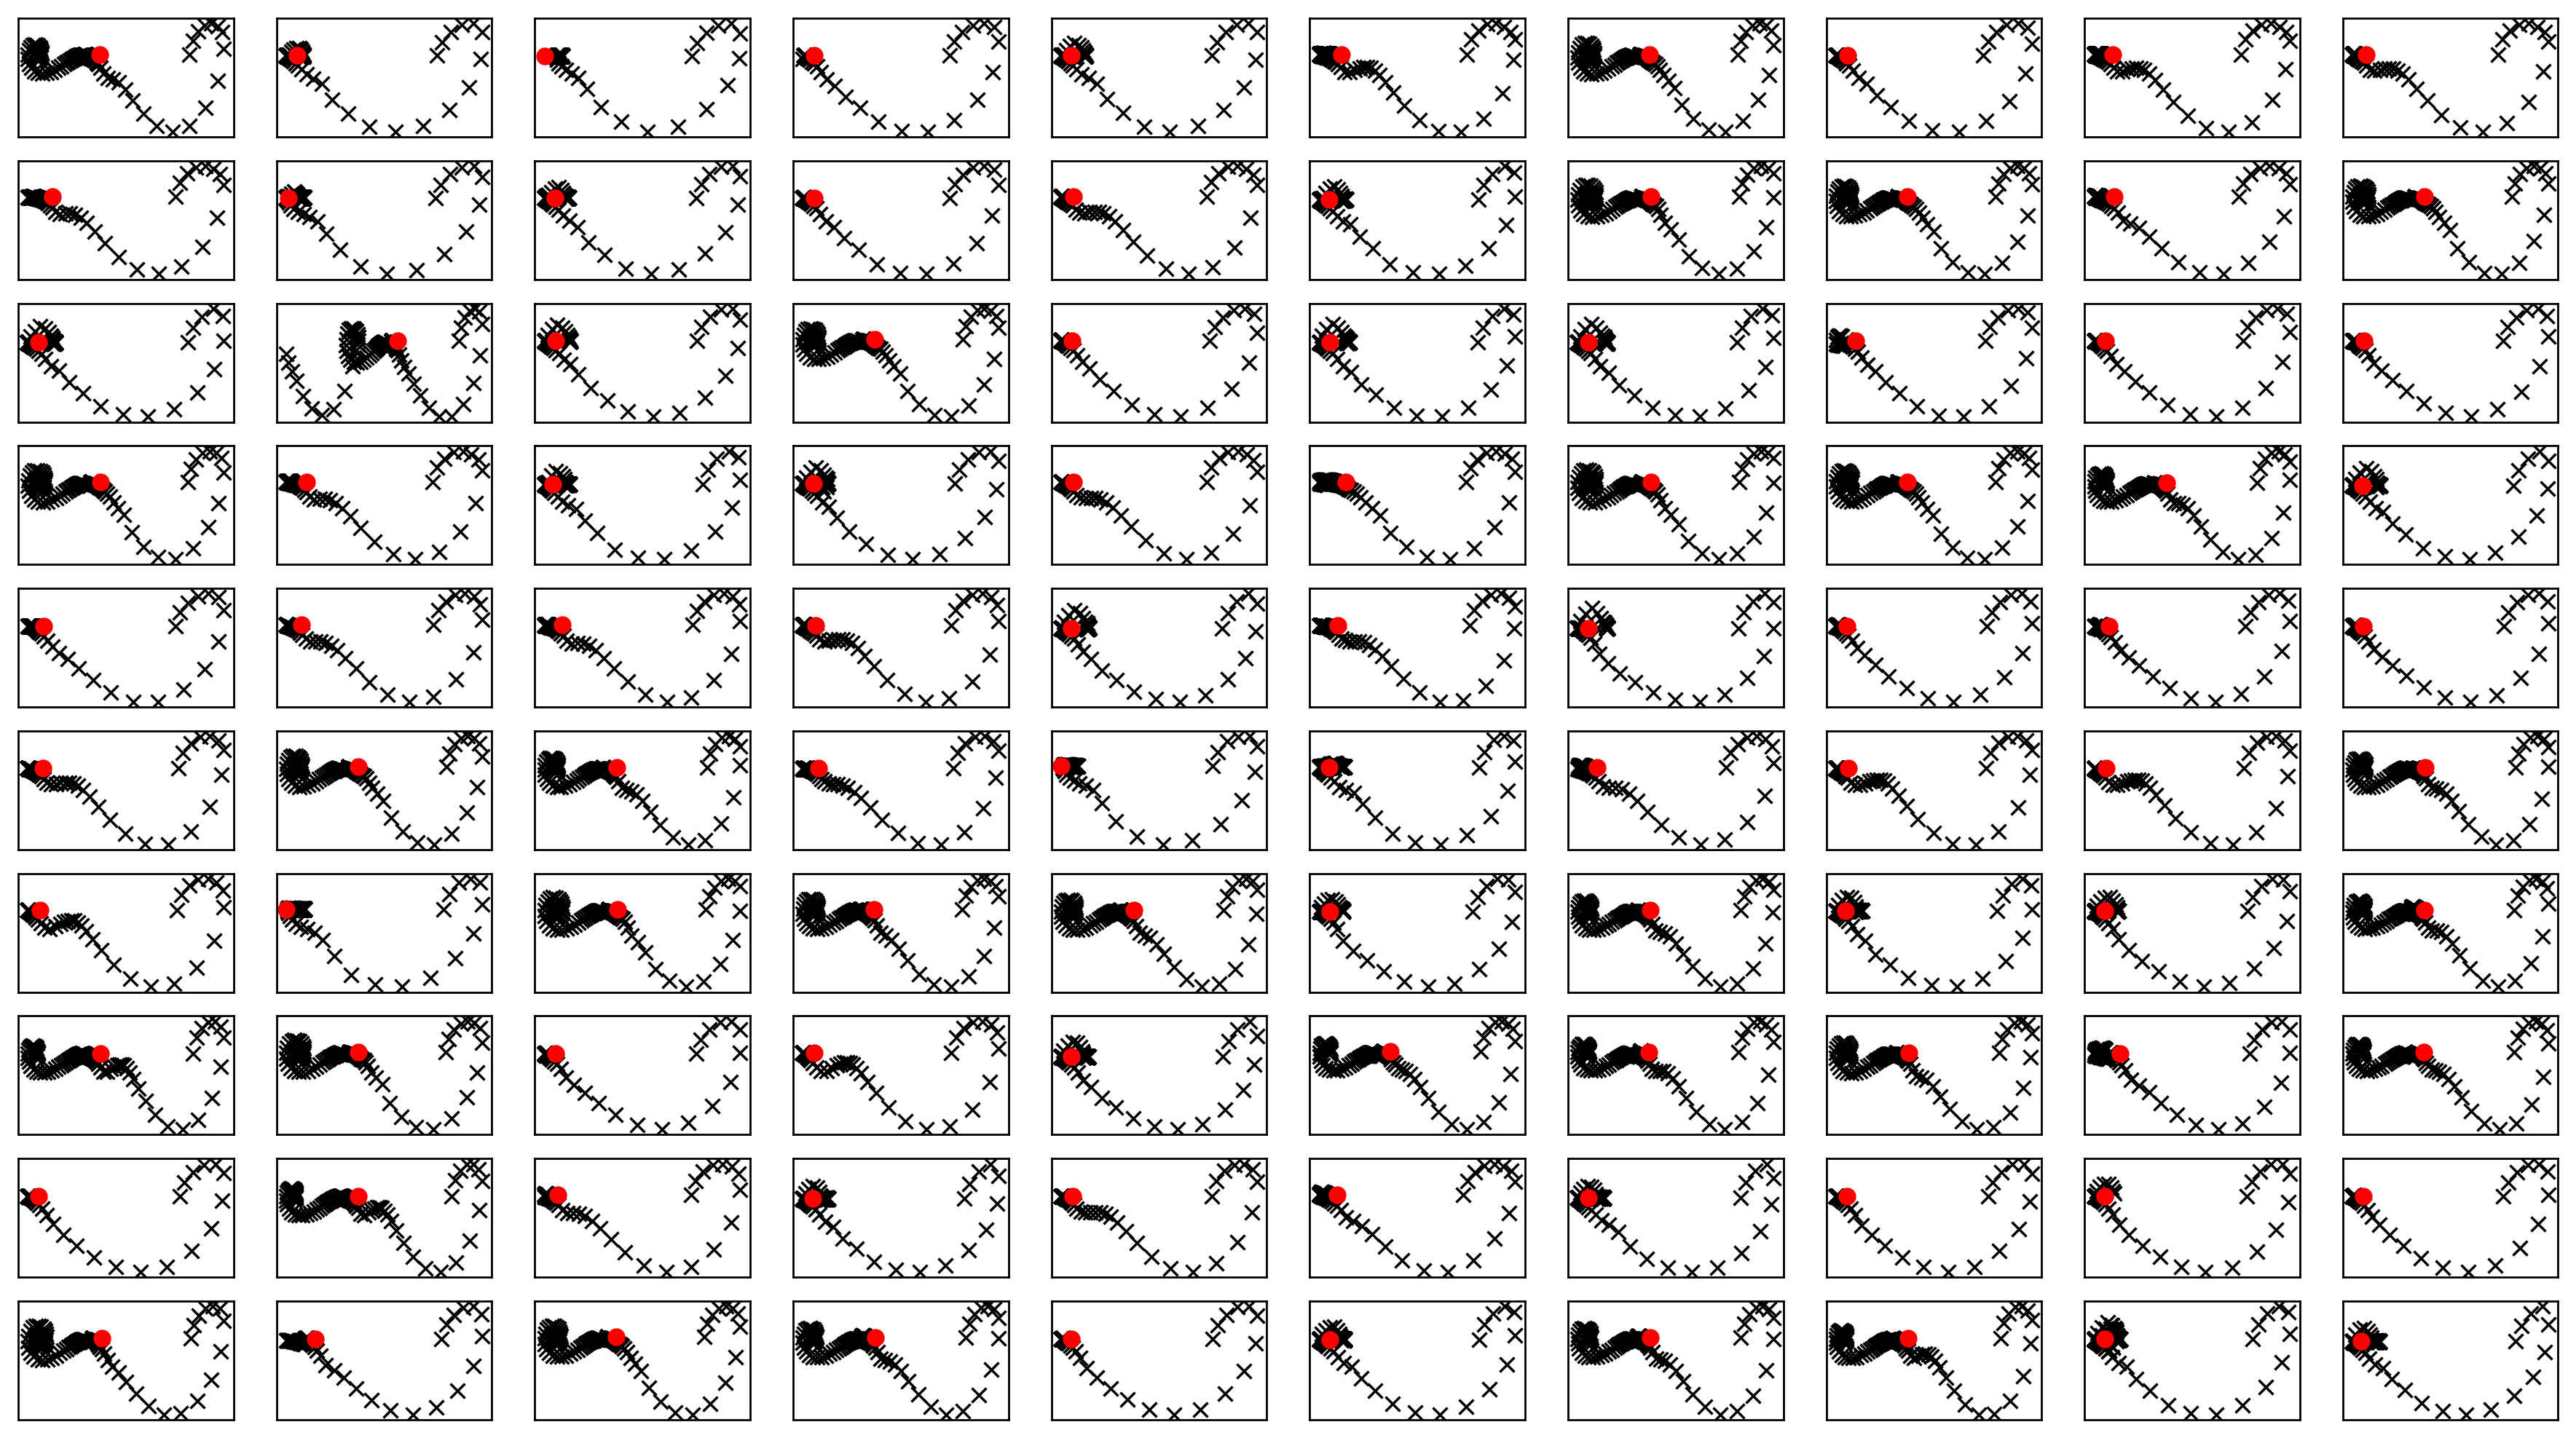

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 8.219486236572266

 2 5.844773054122925

 3 8.447141408920288

 4 7.93484902381897

 5 8.022258520126343

 6 8.386943340301514

 7 8.384223937988281

 8 7.819849729537964

 9 4.329961538314819

 10 4.165436506271362

 11 4.111198902130127

 12 3.9757161140441895

 13 6.445007801055908

 14 8.012358903884888

 15 7.8220744132995605


In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())